### File Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from datetime import datetime
import os
from scipy.stats import randint
import joblib

# Pipeline & Modeling
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder

# Linear Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV

# Random Forest
from sklearn.ensemble import RandomForestRegressor

# XGBoost
import xgboost as xgboost
from xgboost import XGBRegressor


# Evaluation Metrices
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import explained_variance_score, mean_absolute_percentage_error
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
from sklearn.metrics import mean_absolute_percentage_error


# Load Data
df_before_cleaning = pd.read_csv('../data/eda_FE.csv')
df = df_before_cleaning
df.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,lat,long,sqft_living15,price_log,basement_flag,renovated_flag,house_age
0,3,1.00,7.074117,8.639588,1.0,0,0,3,7,0.000000,47.5112,-122.257,7.201171,12.309987,0,0,71
1,3,2.25,7.852050,8.887791,2.0,0,0,3,7,5.993961,47.7210,-122.319,7.433075,13.195616,1,1,75
2,2,1.00,6.647688,9.210440,1.0,0,0,3,6,0.000000,47.7379,-122.233,7.908755,12.100718,0,0,93
3,4,3.00,7.581210,8.517393,1.0,0,0,5,7,6.814543,47.5208,-122.393,7.215975,13.311331,1,0,61
4,3,2.00,7.427144,8.997271,1.0,0,0,3,8,0.000000,47.6168,-122.045,7.496097,13.142168,0,0,39


## 4. Model Pipeline and Evaluation

### 4.1 Data Preparation for Modeling

In [2]:
X = df.drop(columns=['price_log'])
y = df['price_log']

#### 4.1.1 Feature Type Identification
**Separating numeric and categorical features**

In [3]:
X[['basement_flag','renovated_flag']] = X[['basement_flag','renovated_flag']].astype('category')
X.dtypes

bedrooms             int64
bathrooms          float64
sqft_living        float64
sqft_lot           float64
floors             float64
waterfront           int64
view                 int64
condition            int64
grade                int64
sqft_basement      float64
lat                float64
long               float64
sqft_living15      float64
basement_flag     category
renovated_flag    category
house_age            int64
dtype: object

In [4]:
numeric_features = X.select_dtypes(include='number').columns.tolist()
categorical_features = X.select_dtypes(include='category').columns.tolist()

#### 4.1.2 Preprocessing Pipeline Setup
**StandardScaler for numeric features, OneHotEncoder for categorical features**

In [5]:
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown="ignore"))
])

In [6]:
preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

#### 4.1.3 Train-Test Split
**70-30 split with random seed for reproducibility**

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 4.2 Evaluation Metrics Definition
*Custom evaluation function with R², RMSE, MAE, and MAPE metrics*

In [8]:
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Model"):
    
    y_pred_train_log = model.predict(X_train)
    y_pred_test_log = model.predict(X_test)
    
    y_train_original = np.expm1(y_train)
    y_test_original = np.expm1(y_test)
    y_pred_train_original = np.expm1(y_pred_train_log)
    y_pred_test_original = np.expm1(y_pred_test_log)

    mape = mean_absolute_percentage_error(y_test_original, y_pred_test_original)
    accuracy_pct = (1 - mape) * 100
    
    metrics = {
        'train_r2': r2_score(y_train_original, y_pred_train_original),
        'test_r2': r2_score(y_test_original, y_pred_test_original),
        'train_rmse': rmse(y_train_original, y_pred_train_original),
        'test_rmse': rmse(y_test_original, y_pred_test_original),
        'train_mae': mean_absolute_error(y_train_original, y_pred_train_original),
        'test_mae': mean_absolute_error(y_test_original, y_pred_test_original),
        'mape': mean_absolute_percentage_error(y_test_original, y_pred_test_original),
        'acc_mape_pct': accuracy_pct
    }
    
    print(f"\n{model_name} RESULTS")
    print("-" * 40)
    print(f"Train R²: {metrics['train_r2']:.4f}")
    print(f"Test R²: {metrics['test_r2']:.4f}")
    print(f"Train RMSE: {metrics['train_rmse']:.2f}")
    print(f"Test RMSE: {metrics['test_rmse']:.2f}")
    print(f"Train MAE: {metrics['train_mae']:.2f}")
    print(f"Test MAE: {metrics['test_mae']:.2f}")
    print(f"Test MAE Percentage Error: {metrics['mape']:.2f}")
    print(f"Test MAE Accuracy: {metrics['acc_mape_pct']:.2f}")


    return metrics

### 4.3 Model Training and Evaluation

#### 4.3.1 Linear Regression
*Baseline model performance*

In [9]:
linear_pipeline = Pipeline([
    ('preprocessor', preprocess),
    ('regressor', LinearRegression())
])

linear_pipeline.fit(X_train, y_train)

lr_metrics = evaluate_model(
    model=linear_pipeline,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    model_name="LINEAR REGRESSION"
)


LINEAR REGRESSION RESULTS
----------------------------------------
Train R²: 0.7441
Test R²: 0.7366
Train RMSE: 182827.24
Test RMSE: 194997.40
Train MAE: 108006.34
Test MAE: 111995.74
Test MAE Percentage Error: 0.20
Test MAE Accuracy: 80.04


#### 4.3.2 Ridge Regression
*Regularized linear model to prevent overfitting*

In [10]:
ridge_pipeline = Pipeline([
    ('preprocessor', preprocess),
    ('regressor', Ridge(random_state=42))
])

ridge_pipeline.fit(X_train, y_train)

ridge_metrics = evaluate_model(
    model=ridge_pipeline,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    model_name="RIDGE REGRESSION"
)


RIDGE REGRESSION RESULTS
----------------------------------------
Train R²: 0.7442
Test R²: 0.7366
Train RMSE: 182821.84
Test RMSE: 194996.20
Train MAE: 108005.46
Test MAE: 111997.07
Test MAE Percentage Error: 0.20
Test MAE Accuracy: 80.03


#### 4.3.3 Random Forest
*Initial random forest model with feature importance analysis*

In [11]:
rf_pipeline = Pipeline([
    ('preprocessor', preprocess),
    ('regressor', RandomForestRegressor(random_state=42))
])


rf_pipeline.fit(X_train, y_train)


rf_metrics = evaluate_model(
    model=rf_pipeline,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    model_name="RANDOM FOREST"
)


RANDOM FOREST RESULTS
----------------------------------------
Train R²: 0.9782
Test R²: 0.8606
Train RMSE: 53317.93
Test RMSE: 141856.73
Train MAE: 26819.30
Test MAE: 74188.14
Test MAE Percentage Error: 0.13
Test MAE Accuracy: 86.79


In [12]:
best_rf = rf_pipeline
feature_names = (best_rf.named_steps['preprocessor']
                 .get_feature_names_out()
                 .tolist())

importances = best_rf.named_steps['regressor'].feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features for Random Forest:")
print(feature_importance_df.head(10))


Top 10 Most Important Features for Random Forest:
               feature  importance
8           num__grade    0.350784
10            num__lat    0.294600
2     num__sqft_living    0.185135
11           num__long    0.050284
12  num__sqft_living15    0.029436
13      num__house_age    0.025186
3        num__sqft_lot    0.024923
6            num__view    0.008665
1       num__bathrooms    0.006483
5      num__waterfront    0.005953


#### 4.3.4 Random Forest Hyperparameter Tuning
*RandomizedSearchCV optimization for random forest*

In [13]:
rf_tuned = Pipeline([
    ('preprocessor', preprocess),
    ('regressor', RandomForestRegressor(
        n_estimators=234,
        max_depth=20,
        max_features=0.7,
        min_samples_split=19,
        min_samples_leaf=12,
        bootstrap=False,
        random_state=42))
])


print("Starting Tuned Random Forest...")
rf_tuned.fit(X_train, y_train)

rf_tuned_metrics = evaluate_model(
    model=rf_tuned,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    model_name="RANDOM FOREST TUNED"
)


Starting Tuned Random Forest...

RANDOM FOREST TUNED RESULTS
----------------------------------------
Train R²: 0.8970
Test R²: 0.8425
Train RMSE: 116021.46
Test RMSE: 150772.78
Train MAE: 54542.12
Test MAE: 77947.40
Test MAE Percentage Error: 0.14
Test MAE Accuracy: 86.30


In [14]:
best_rf_tuned = rf_tuned
feature_names = (best_rf_tuned.named_steps['preprocessor']
                 .get_feature_names_out()
                 .tolist())

importances = best_rf_tuned.named_steps['regressor'].feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features for Tuned Random Forest:")
print(feature_importance_df.head(10))


Top 10 Most Important Features for Tuned Random Forest:
               feature  importance
10            num__lat    0.316340
8           num__grade    0.294974
2     num__sqft_living    0.253373
11           num__long    0.039499
12  num__sqft_living15    0.034544
13      num__house_age    0.021509
3        num__sqft_lot    0.014929
6            num__view    0.008875
1       num__bathrooms    0.008271
7       num__condition    0.002512


#### 4.3.5 XGBoost
*Initial gradient boosting model performance*

In [15]:
xgbm_pipeline = Pipeline([
    ('preprocessor', preprocess),
    ('regressor', XGBRegressor(random_state=42))
])

xgbm_pipeline.fit(X_train, y_train)

xgbm_metrics = evaluate_model(
    model=xgbm_pipeline,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    model_name="XGBOOST"
)


XGBOOST RESULTS
----------------------------------------
Train R²: 0.9705
Test R²: 0.8917
Train RMSE: 62050.35
Test RMSE: 125039.72
Train MAE: 40668.92
Test MAE: 68420.93
Test MAE Percentage Error: 0.13
Test MAE Accuracy: 87.50


In [16]:
best_xgbm = xgbm_pipeline
feature_names = (best_xgbm.named_steps['preprocessor']
                 .get_feature_names_out()
                 .tolist())

importances = best_xgbm.named_steps['regressor'].feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features for XGBoost:")
print(feature_importance_df.head(10))


Top 10 Most Important Features for XGBoost:
                  feature  importance
8              num__grade    0.566816
10               num__lat    0.121160
2        num__sqft_living    0.091357
5         num__waterfront    0.076267
6               num__view    0.041802
11              num__long    0.018435
12     num__sqft_living15    0.016440
7          num__condition    0.014264
13         num__house_age    0.013404
16  cat__renovated_flag_0    0.011559


#### 4.3.6 XGBoost Hyperparameter Tuning
*Optimized XGBoost with hyperparameter tuning*

In [17]:
xgbm_pipeline = Pipeline([
    ('preprocessor', preprocess),
    ('regressor', XGBRegressor(random_state=42))
])


xgbm_param_dist = {
    'regressor__n_estimators': [200, 300, 400],
    'regressor__max_depth': [5, 7, 10],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__subsample': [0.8, 1.0],
    'regressor__colsample_bytree': [0.8, 1.0]
}

xgbm_tuned = RandomizedSearchCV(
    xgbm_pipeline,
    param_distributions=xgbm_param_dist,
    n_iter=20, 
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=42,
    n_jobs=-1,
    verbose=2
)

print("Starting RandomizedSearchCV...")
xgbm_tuned.fit(X_train, y_train)


print("\nBest Parameters:")
print(xgbm_tuned.best_params_)


xgbm_tuned_metrics = evaluate_model(
    model=xgbm_tuned.best_estimator_,
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    model_name="XGBOOST TUNED"
)

Starting RandomizedSearchCV...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best Parameters:
{'regressor__subsample': 0.8, 'regressor__n_estimators': 400, 'regressor__max_depth': 7, 'regressor__learning_rate': 0.05, 'regressor__colsample_bytree': 0.8}

XGBOOST TUNED RESULTS
----------------------------------------
Train R²: 0.9738
Test R²: 0.9044
Train RMSE: 58471.06
Test RMSE: 117476.65
Train MAE: 37497.93
Test MAE: 64787.75
Test MAE Percentage Error: 0.12
Test MAE Accuracy: 88.09


In [18]:
best_xgbm_tuned = xgbm_tuned.best_estimator_
feature_names = (best_xgbm_tuned.named_steps['preprocessor']
                 .get_feature_names_out()
                 .tolist())

importances = best_xgbm_tuned.named_steps['regressor'].feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features for Tuned XGBoost:")
print(feature_importance_df.head(10))


Top 10 Most Important Features for Tuned XGBoost:
               feature  importance
8           num__grade    0.485137
10            num__lat    0.135415
2     num__sqft_living    0.097812
5      num__waterfront    0.064523
6            num__view    0.041547
12  num__sqft_living15    0.040550
11           num__long    0.022718
13      num__house_age    0.018412
1       num__bathrooms    0.016814
7       num__condition    0.014386


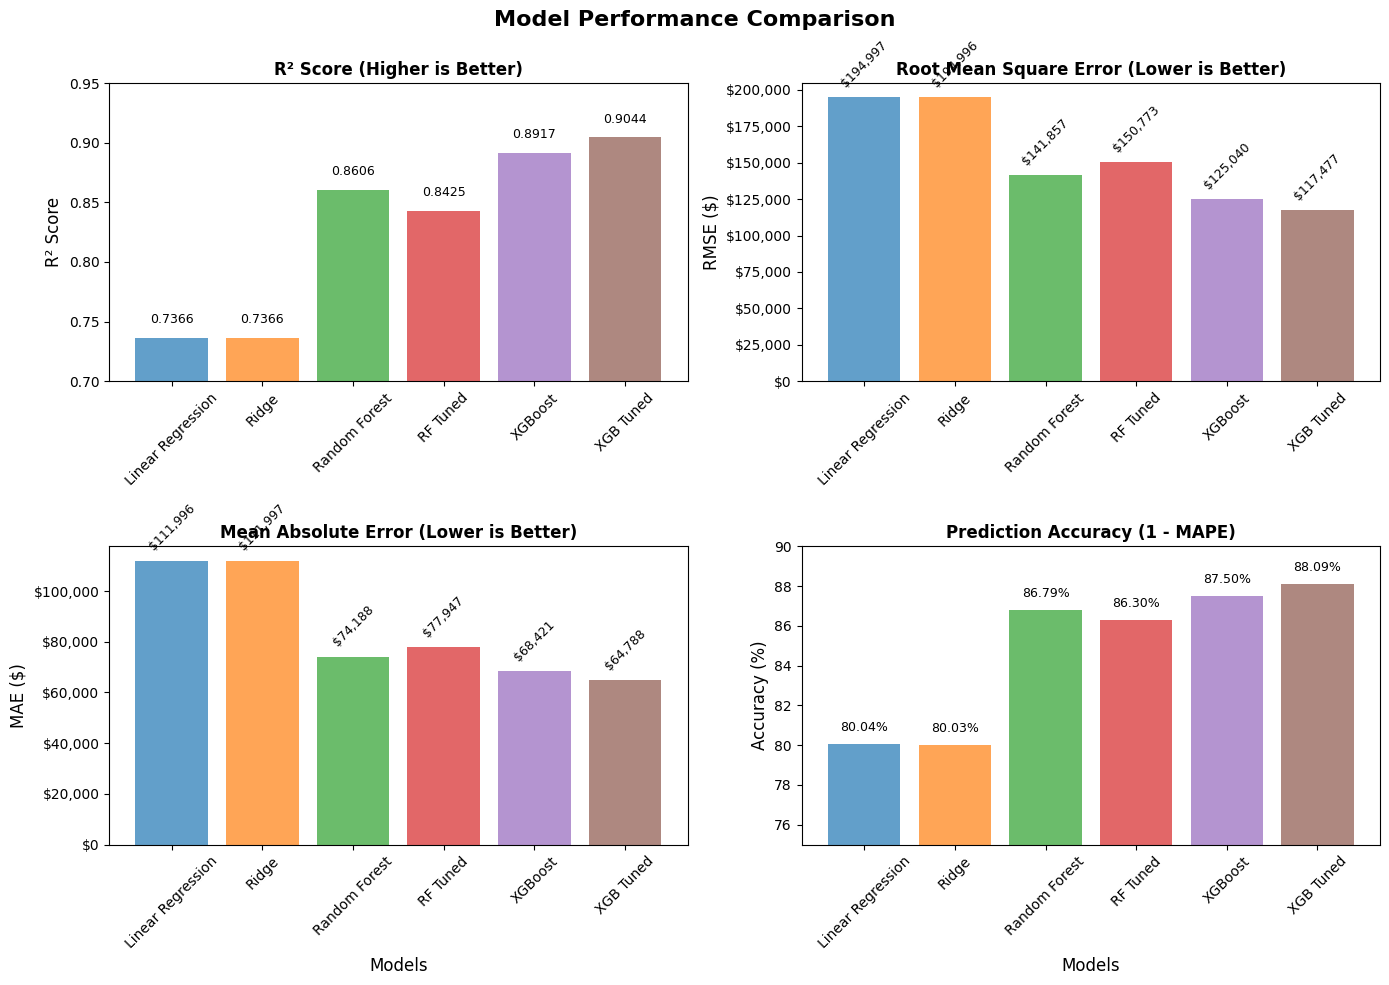


MODEL PERFORMANCE SUMMARY
Model                R²       RMSE         MAE          Accuracy
------------------------------------------------------------
Linear Regression    0.7366   $194,997    $111,996    80.04 %
Ridge                0.7366   $194,996    $111,997    80.03 %
Random Forest        0.8606   $141,857    $74,188     86.79 %
RF Tuned             0.8425   $150,773    $77,947     86.30 %
XGBoost              0.8917   $125,040    $68,421     87.50 %
XGB Tuned            0.9044   $117,477    $64,788     88.09 %
🏆 Best Model: XGBoost Tuned
   - R²: 0.9044
   - RMSE: $117,477
   - MAE: $64,788
   - Accuracy: 88.09%


In [24]:
# Your data
models = ['Linear Regression', 'Ridge', 'Random Forest', 'RF Tuned', 'XGBoost', 'XGB Tuned']
test_r2 = [0.7366, 0.7366, 0.8606, 0.8425, 0.8917, 0.9044]
test_rmse = [194997, 194996, 141857, 150773, 125040, 117477]
test_mae = [111996, 111997, 74188, 77947, 68421, 64788]
accuracy = [80.04, 80.03, 86.79, 86.30, 87.50, 88.09]

# Set style
plt.style.use('default')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

# Create figure with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

# 1. R² Score Plot
ax1 = axes[0, 0]
bars1 = ax1.bar(models, test_r2, color=colors, alpha=0.7)
ax1.set_ylabel('R² Score', fontsize=12)
ax1.set_title('R² Score (Higher is Better)', fontsize=12, fontweight='bold')
ax1.set_ylim(0.7, 0.95)
ax1.tick_params(axis='x', rotation=45)
# Add value labels
for bar, val in zip(bars1, test_r2):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{val:.4f}', ha='center', va='bottom', fontsize=9)

# 2. RMSE Plot
ax2 = axes[0, 1]
bars2 = ax2.bar(models, test_rmse, color=colors, alpha=0.7)
ax2.set_ylabel('RMSE ($)', fontsize=12)
ax2.set_title('Root Mean Square Error (Lower is Better)', fontsize=12, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
# Format y-axis as currency
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
# Add value labels
for bar, val in zip(bars2, test_rmse):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5000, 
             f'${val:,.0f}', ha='center', va='bottom', fontsize=9, rotation=45)

# 3. MAE Plot
ax3 = axes[1, 0]
bars3 = ax3.bar(models, test_mae, color=colors, alpha=0.7)
ax3.set_ylabel('MAE ($)', fontsize=12)
ax3.set_xlabel('Models', fontsize=12)
ax3.set_title('Mean Absolute Error (Lower is Better)', fontsize=12, fontweight='bold')
ax3.tick_params(axis='x', rotation=45)
ax3.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
# Add value labels
for bar, val in zip(bars3, test_mae):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 3000, 
             f'${val:,.0f}', ha='center', va='bottom', fontsize=9, rotation=45)

# 4. Accuracy Plot
ax4 = axes[1, 1]
bars4 = ax4.bar(models, accuracy, color=colors, alpha=0.7)
ax4.set_ylabel('Accuracy (%)', fontsize=12)
ax4.set_xlabel('Models', fontsize=12)
ax4.set_title('Prediction Accuracy (1 - MAPE)', fontsize=12, fontweight='bold')
ax4.set_ylim(75, 90)
ax4.tick_params(axis='x', rotation=45)
# Add value labels
for bar, val in zip(bars4, accuracy):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{val:.2f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*60)
print("MODEL PERFORMANCE SUMMARY")
print("="*60)
print(f"{'Model':<20} {'R²':<8} {'RMSE':<12} {'MAE':<12} {'Accuracy':<8}")
print("-"*60)
for i, model in enumerate(models):
    print(f"{model:<20} {test_r2[i]:<8.4f} ${test_rmse[i]:<10,.0f} ${test_mae[i]:<10,.0f} {accuracy[i]:<6.2f}%")
print("="*60)
print(f"🏆 Best Model: XGBoost Tuned")
print(f"   - R²: {test_r2[-1]:.4f}")
print(f"   - RMSE: ${test_rmse[-1]:,.0f}")
print(f"   - MAE: ${test_mae[-1]:,.0f}")
print(f"   - Accuracy: {accuracy[-1]:.2f}%")

Saving Model

In [20]:
import joblib

# Save best tuned model
joblib.dump(xgbm_tuned.best_estimator_, "model.joblib")

['model.joblib']

In [21]:
import json

interval_data = {
    "mae": 64787.75
}

with open("interval.json", "w") as f:
    json.dump(interval_data, f)

In [22]:
loaded_model = joblib.load("model.joblib")
loaded_model.predict(X_test.iloc[[0]])

array([12.872642], dtype=float32)